In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [3]:
from problems import Poisson3D
problem = Poisson3D()

In [4]:
X, Y, Z, u_solution = problem.exact_solution(64, 64, 64)

print(u_solution.shape)

(64, 64, 64)


# Optimiser

In [5]:
class MonoMinLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        max_trials: int = 100,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        collocation_points
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        # This vectorized function will be used for the initial loss calculation
        def vectorized_residual_fn(p):
            return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        residuals = vectorized_residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        def single_row_jacobian_fn(p_flat, xt):
            # ... (Jacobian calculation code is correct) ...
            static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
            def residual_for_jac(p_flat_local):
                model = eqx.combine(unflatten(p_flat_local), static)
                return residual_fn(model, xt).sum()
            
            return jax.grad(residual_for_jac)(p_flat)
        
        J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        Hessian_diag = jnp.sum(J**2, axis=0)
        D = jnp.diag(jnp.sqrt(Hessian_diag))
        J_hat = J @ jnp.linalg.inv(D)
        
        U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        g_hat = U_hat.T @ residuals

        # U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        # g = U.T @ residuals

        def evaluate_trial_step(loop_val):
            _, trial_lambda, previous_trial_loss, _, trial_count = loop_val
            # delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            delta_hat = -Vt_hat.T @ jnp.diag(S_hat / (S_hat**2 + trial_lambda)) @ g_hat
            delta = jnp.linalg.inv(D) @ delta_hat
            
            trial_params = eqx.apply_updates(params, unflatten(delta))
            
            # Use the vectorized_residual_fn to correctly compute residuals for all points
            trial_residuals = vectorized_residual_fn(trial_params)
            
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = (trial_loss < current_loss) & (trial_loss > 0.99 * previous_trial_loss)

            # If rejected, increase lambda for the next trial
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda,
                lambda: trial_lambda * self.increase_factor
            )
            
            return accepted, new_lambda, trial_loss, delta, trial_count + 1

        def continue_search(loop_val):
            # Continue if step not accepted AND we haven't exceeded max trials
            accepted, _, trial_loss, _, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
        
        # Run the search loop
        initial_loop_val = (False, current_lambda, current_loss, jnp.zeros_like(params_flat), 0)
        
        accepted, final_lambda, new_loss, final_delta, count = jax.lax.while_loop(
            continue_search, evaluate_trial_step, initial_loop_val
        )

        updates = unflatten(final_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S_hat, #S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
            'trial_count': count
        }

        return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, 
    candidate_points, 
    n_points_to_sample, 
    problem, # Pass the problem instance for its residual function
    k, # RAD hyperparameter
    c, # RAD hyperparameter
    key
):
    # 1. Calculate PDE residuals for all candidate points
    # Call the vmapped physics_residual function with the model and the batch of points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key, 
        a=candidate_points.shape[0], 
        shape=(n_points_to_sample,), 
        p=probs,
        replace=False # Sample without replacement
    )
    
    return candidate_points[indices]

In [6]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**14
n_candidate_points = 10 * n_collocation_points # Much larger pool
layer_sizes = [3, 20, 20, 20, 20, 1]
# -----------------------

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 50
rad_k = 1.5
rad_c = 1.0
# -----------------------------------

model_key, data_key, resample_key = jax.random.split(key, 3)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

# 1. Generate the candidate pool ONCE
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)

# 2. Get the initial set of collocation points
collocation_points = jax.random.choice(data_key, candidate_points, shape=(n_collocation_points,), replace=False)

start_time = time.monotonic()

epoch = 0

In [7]:
optimiser = MonoMinLM(
    init_lambda=1e5,
    decrease_factor=0.5,
    increase_factor=1.01,
    max_trials=100,
)
opt_state = optimiser.init(params)

In [8]:
resample_every_n_epochs = 100
rad_k = 0.0
rad_c = 1.0

In [14]:
for _ in range(300):
    epoch += 1
    
    # 3. Periodically resample points using RAD
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        resample_key, subkey = jax.random.split(resample_key)
        
        # We need the full model to calculate residuals for resampling
        current_model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            current_model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )
        
    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 510, Loss: 3.567e-05, Time elapsed: 3995.17 s
Epoch 520, Loss: 3.178e-05, Time elapsed: 4006.02 s
Epoch 530, Loss: 2.838e-05, Time elapsed: 4017.26 s
Epoch 540, Loss: 2.683e-05, Time elapsed: 4028.96 s
Epoch 550, Loss: 2.485e-05, Time elapsed: 4040.38 s
Epoch 560, Loss: 2.337e-05, Time elapsed: 4050.02 s
Epoch 570, Loss: 2.250e-05, Time elapsed: 4059.92 s
Epoch 580, Loss: 2.179e-05, Time elapsed: 4070.39 s
Epoch 590, Loss: 2.114e-05, Time elapsed: 4080.11 s
Epoch 600, Loss: 2.031e-05, Time elapsed: 4090.51 s
Epoch 610, Loss: 2.623e-05, Time elapsed: 4100.46 s
Epoch 620, Loss: 2.301e-05, Time elapsed: 4110.44 s
Epoch 630, Loss: 2.097e-05, Time elapsed: 4121.03 s
Epoch 640, Loss: 2.017e-05, Time elapsed: 4131.29 s
Epoch 650, Loss: 1.921e-05, Time elapsed: 4140.93 s
Epoch 660, Loss: 1.830e-05, Time elapsed: 4151.28 s
Epoch 670, Loss: 1.744e-05, Time elapsed: 4162.16 s
Epoch 680, Loss: 1.695e-05, Time elapsed: 4172.63 s
Epoch 690, Loss: 1.635e-05, Time elapsed: 4182.81 s
Epoch 700, L

In [12]:
model = eqx.combine(params, static)

u_pred = model.predict(X, Y, Z)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 3.191e-04


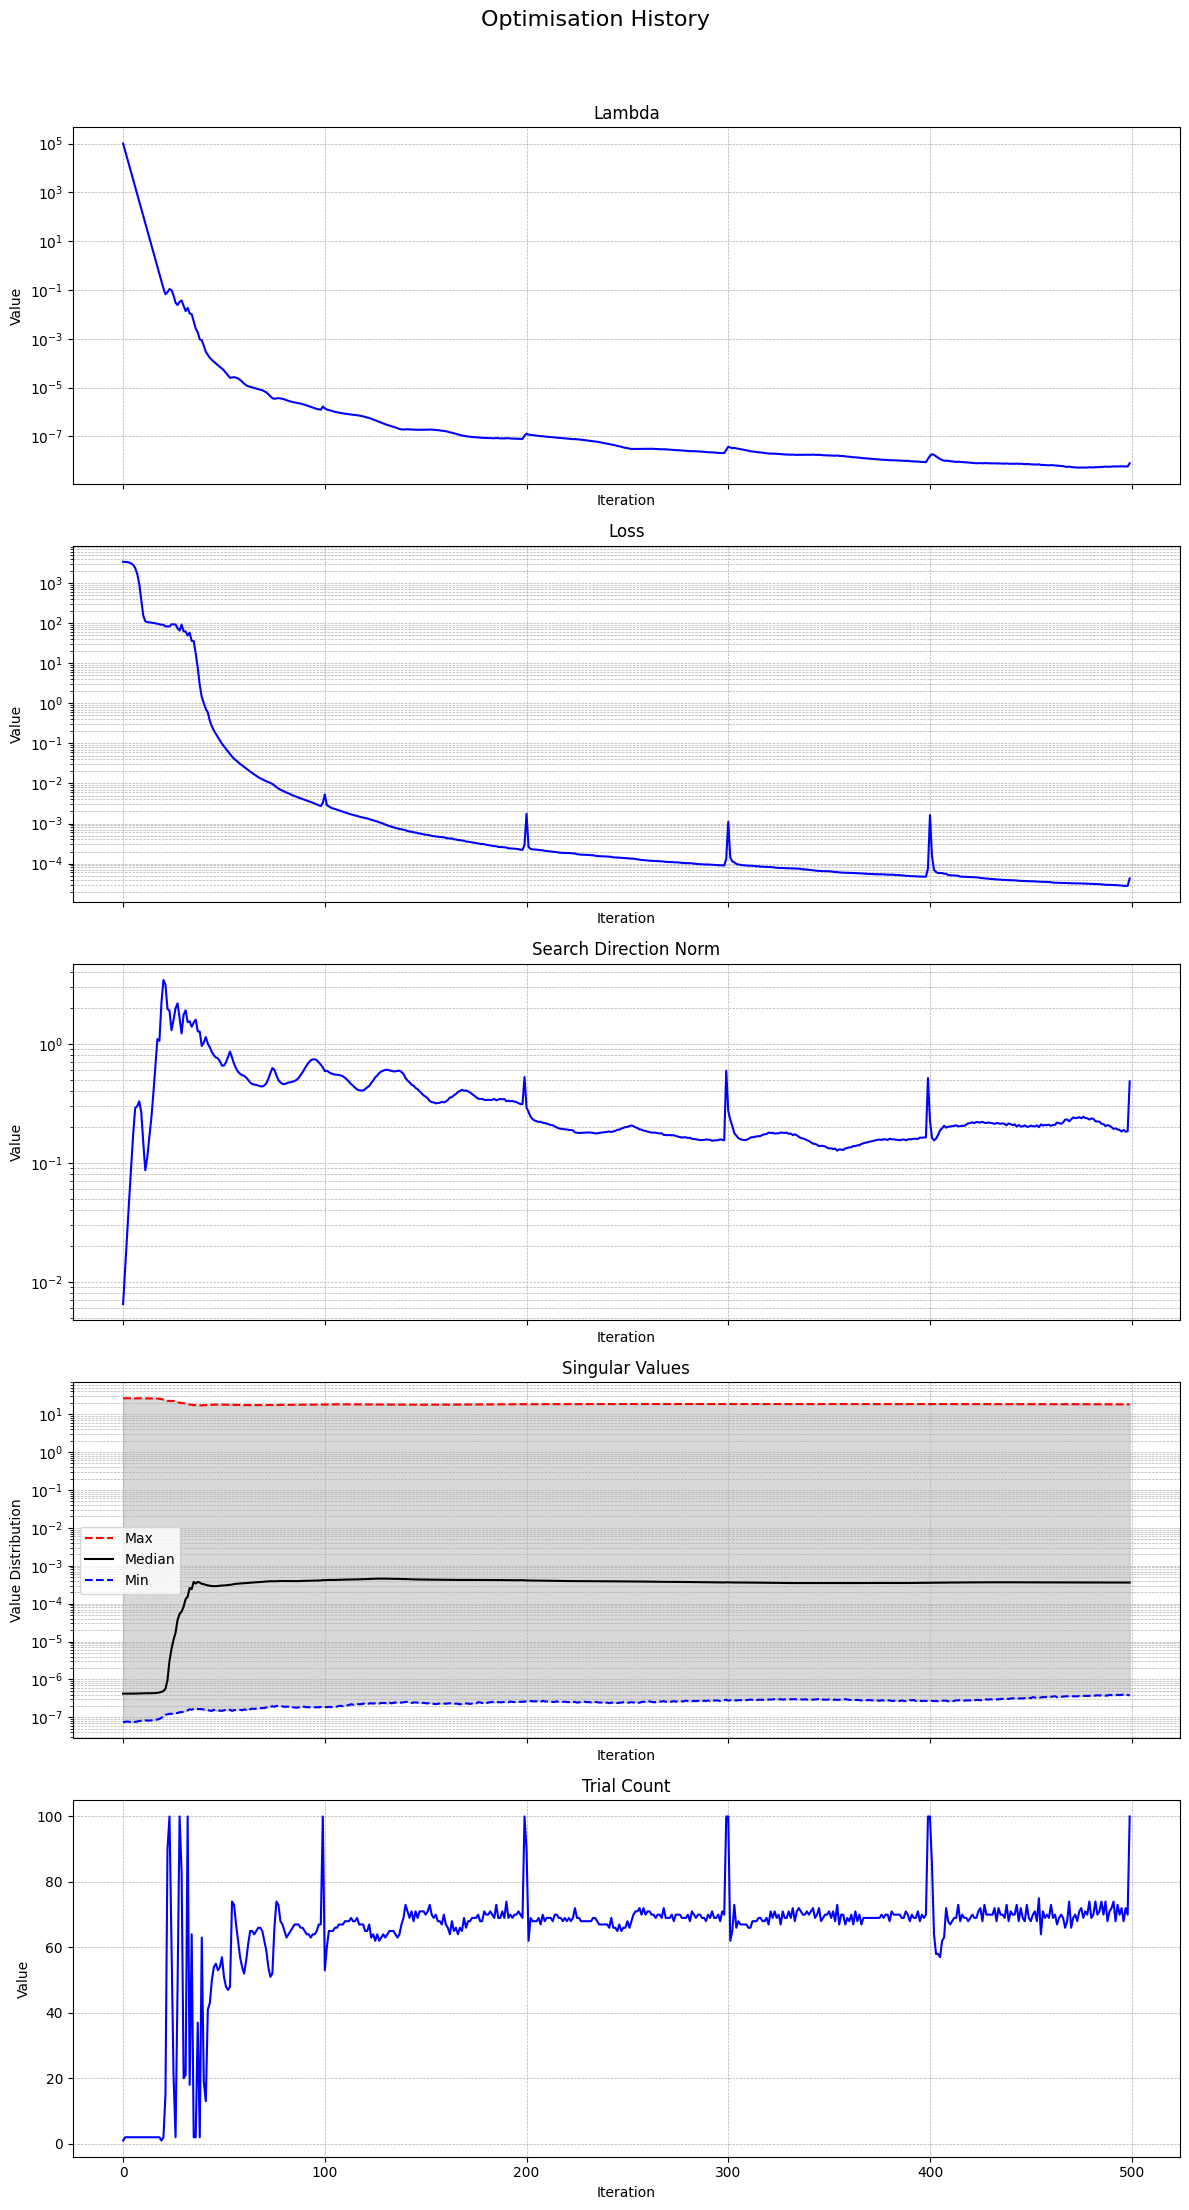

In [13]:
history.plot()